In [2]:
# Setup plotting
import matplotlib.pyplot as plt
# print(plt.style.available)
plt.style.use('seaborn-v0_8')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

print("Setup Matplotlib...")

Setup Matplotlib...


First, load the Hotel Cancellations dataset.

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

1) Define Model
The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid')
])

c:\Users\agrim\OneDrive\Desktop\Deep Learning\Softcomputing-23-Course\Hotel-Cancellation\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



2) Add Optimizer, Loss, and Metric
Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [5]:
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['binary_accuracy'])

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - binary_accuracy: 0.7415 - loss: 0.5416 - val_binary_accuracy: 0.8020 - val_loss: 0.4349
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - binary_accuracy: 0.7997 - loss: 0.4297 - val_binary_accuracy: 0.8103 - val_loss: 0.4021
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.8101 - loss: 0.4105 - val_binary_accuracy: 0.8135 - val_loss: 0.3936
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - binary_accuracy: 0.8120 - loss: 0.4028 - val_binary_accuracy: 0.8179 - val_loss: 0.3903
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.8141 - loss: 0.3977 - val_binary_accuracy: 0.8194 - val_loss: 0.3917
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.8164 - loss: 0.3933 - val_binary_accuracy: 0.8207 - val_loss: 0.3859
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - binary_accuracy: 0.8219 - loss: 0.3883 - val_binary_accuracy: 0.8219 - val_loss

<Axes: title={'center': 'Accuracy'}>

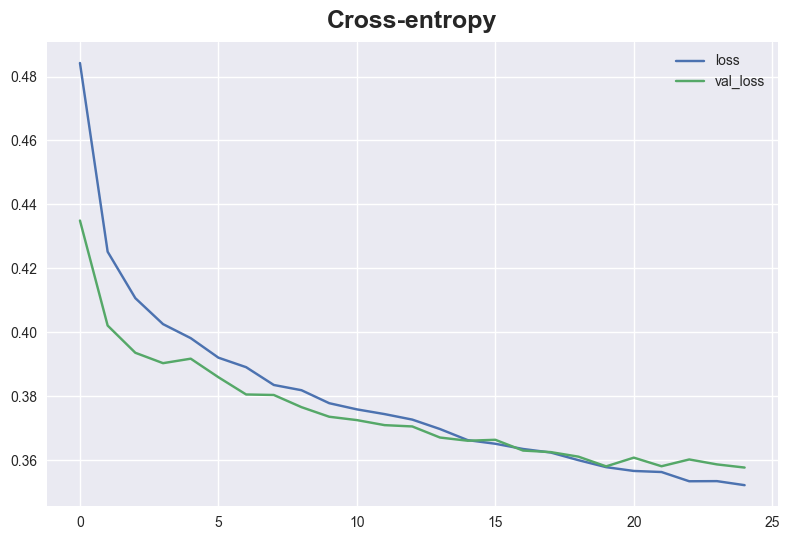

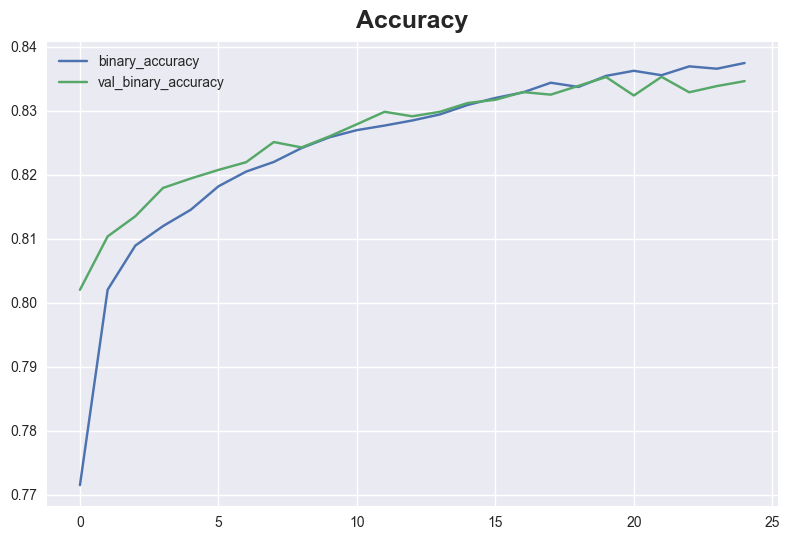

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")